In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install -q transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import AutoTokenizer
import tensorflow as tf
from transformers import TFAutoModel
import transformers

In [6]:
train_df = pd.read_csv('/content/drive/My Drive/Dataset/train.csv')
print(train_df.shape)

(7613, 5)


In [10]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
train_df.drop_duplicates('text', keep='first')
train_df.shape

(7613, 5)

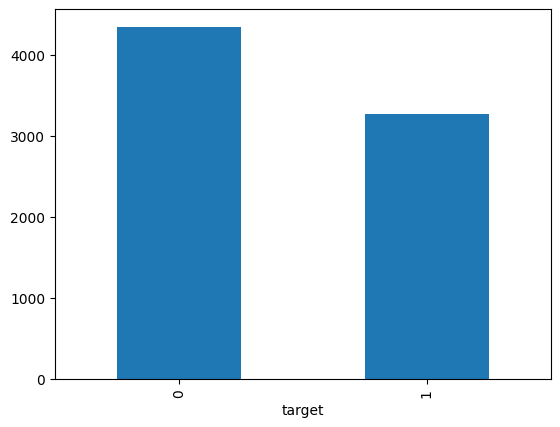

In [14]:
train_df.target.value_counts().plot(kind = 'bar') ;

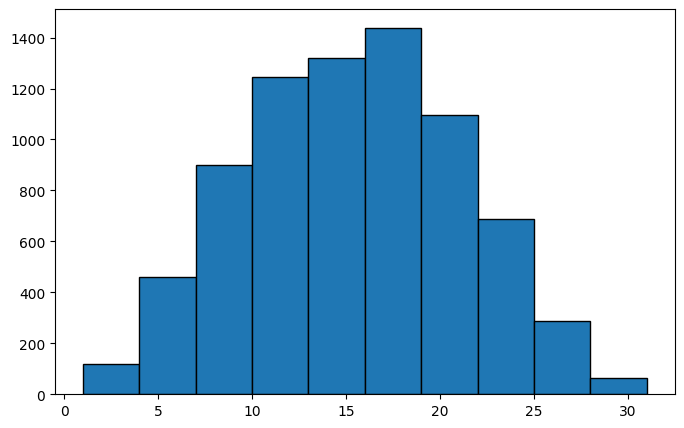

In [15]:
textlen = train_df['text'].apply(lambda x: len(x.split()))

import seaborn as sns
plt.figure(figsize=(8,5))
plt.hist(textlen, edgecolor = "black");

In [7]:
SEQ_LEN = 30

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace("#","")
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")

In [10]:
train_df['text'] = train_df['text'].apply(preprocess)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [11]:
train_encoded_inputs = tokenizer(train_df['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=SEQ_LEN,
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, train_df['target'].values))

In [13]:
def map_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}

  return inputs, labels

In [14]:
train_dataset = train_dataset.map(map_bert)

In [15]:
dataset = train_dataset.shuffle(100000).batch(64)

In [16]:
DS_LEN = len(dataset)
DS_LEN

119

In [17]:
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

In [18]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [19]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [20]:
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 30)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 30)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 30, 76                                       

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [25]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks
)

Epoch 1/50
95/95 [==============================] - 56s 281ms/step - loss: 0.4341 - accuracy: 0.8041 - val_loss: 0.3544 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 2/50
95/95 [==============================] - 17s 174ms/step - loss: 0.4198 - accuracy: 0.8097 - val_loss: 0.3507 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 3/50
95/95 [==============================] - 16s 172ms/step - loss: 0.4010 - accuracy: 0.8253 - val_loss: 0.3366 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 4/50
95/95 [==============================] - 17s 180ms/step - loss: 0.4048 - accuracy: 0.8247 - val_loss: 0.3356 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 5/50
95/95 [==============================] - 16s 168ms/step - loss: 0.3918 - accuracy: 0.8283 - val_loss: 0.3146 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 6/50
95/95 [==============================] - 16s 169ms/step - loss: 0.3848 - accuracy: 0.8375 - val_loss: 0.3135 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 7/50
95/95 [==============================] - 18s 192ms/st

In [27]:
test_df = pd.read_csv('/content/drive/My Drive/Dataset/test.csv')
test_df.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [28]:
test_df['text'] = test_df['text'].apply(preprocess)

In [30]:
test_encoded_inputs = tokenizer(test_df['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=SEQ_LEN,
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [31]:
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encoded_inputs))

In [32]:
test_ds = test_dataset.shuffle(100000).batch(64)
test_pred = model.predict(test_ds)

51/51 [==============================] - 21s 134ms/step


In [34]:
test_pred

array([[0.32588813],
       [0.8279372 ],
       [0.06744898],
       ...,
       [0.09340808],
       [0.6214863 ],
       [0.04847258]], dtype=float32)